1. Load the data. Make sure you know the coding of all variables. In particular, you should be aware
if a variable is categorical or numeric. Explain the coding scheme if it's not obvious

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from math import log

In [2]:
#Load the data
titanic_df = pd.read_csv('C:/Users/Sakura/Downloads/titanic.csv.bz2')
print(titanic_df.head())


   pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

       age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.0000      0      0   24160  211.3375       B5        S    2    NaN   
1   0.9167      1      2  113781  151.5500  C22 C26        S   11    NaN   
2   2.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   
3  30.0000      1      2  113781  151.5500  C22 C26        S  NaN  135.0   
4  25.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   

                         home.dest  
0                     St 

In [3]:
#Understand data and create dummy variables
summary1=pd.DataFrame(columns=['Column', 'Survived','Drowned'])
xcol=['pclass', 'male', 'age', 'sibsp', 'parch', 'fare',  'embarked_c','embarked_q','dest_NY']

x=pd.DataFrame(titanic_df.groupby(['home.dest'])['survived'].count().reset_index(name='Average'))
#print(x.sort_values(by=['Average'],ascending=False))

def summ(var,summary1):
    f=pd.DataFrame(titanic_df.groupby(['survived'])[var].mean().reset_index(name='Average'))
    f1=[{'Column':var,'Survived':f.iloc[0,1],'Drowned':f.iloc[1,1]}]
    summary1=summary1.append(pd.DataFrame(f1), ignore_index=True)
    return(summary1)


titanic_df['male']= (titanic_df['sex']=='male')*1
titanic_df['embarked_c']= (titanic_df['embarked']=='C')*1
titanic_df['embarked_q']= (titanic_df['embarked']=='Q')*1
titanic_df['dest_NY']= (titanic_df['home.dest']=='New York, NY')*1


for i in range(0,len(xcol)):    
    summary1=summ(xcol[i],summary1 )

print(summary1)

       Column    Drowned   Survived
0      pclass   1.962000   2.500618
1        male   0.322000   0.843016
2         age  28.918228  30.545369
3       sibsp   0.462000   0.521632
4       parch   0.476000   0.328801
5        fare  49.361184  23.353831
6  embarked_c   0.300000   0.148331
7  embarked_q   0.088000   0.097651
8     dest_NY   0.080000   0.029666


I have not considered variables such as ticket,name, cabin as they dont have any impact on survival rate.

I have not consiered variables such as body, boat as they occur at the same time as survival, will not be useful for prediction.

I have created dummy variable only for the destination New York, NY, as other destinations have very few number of records

2.1 Prepare data

1. Now select the variables you are going to use. Use those that may have inuenced survival (such as
class), or those that may be otherwise correlated with survival (like fare).
Note: do not include explanatory variables that are result of survival/death, namely boat number
and body number.

2. Split your data into training/testing groups (80/20% or so)

In [7]:
result1=pd.DataFrame()

x1=['pclass', 'male', 'age', 'sibsp', 'parch', 'fare',  'embarked_c','embarked_q','dest_NY','survived']
X1=titanic_df[x1]
train, test = train_test_split(X1, test_size=0.2, random_state=26)


2.2 Implement the decision tree

In [8]:
#find % split at root node
x=train.groupby('survived')['survived'].count().reset_index(name="count")
y1=(x.iloc[0,1]/(x.iloc[1,1]+x.iloc[0,1]))*100
y2=(x.iloc[1,1]/(x.iloc[1,1]+x.iloc[0,1]))*100
x['percent']=[y1,y2]
print(x)
H=-(y1*log(y1,2))-(y2*log(y2,2))
print(H)


   survived  count    percent
0         0    652  62.273161
1         1    395  37.726839
-568.7766288602395


In [104]:
#Creating the Entropy logic for Age variable
x1=['pclass', 'male', 'age', 'sibsp', 'parch', 'fare',  'embarked_c','embarked_q','dest_NY','survived']
X1=titanic_df[x1]
train, test = train_test_split(X1, test_size=0.2, random_state=26)

train['age'].fillna(np.mean(train['age']), inplace=True)
g=train['age'].unique()
g=sorted(g, key=int) 
g.sort()
c=23

def percen(z):
    x=pd.DataFrame(z.groupby(['survived'])['survived'].count().reset_index(name="count"))
    if(len(x)<=1):
        H=-(1*log(1,2))
        return(H)
    if(len(x)>1):        
        y1=(x.iloc[0,1]/(x.iloc[1,1]+x.iloc[0,1]))
        y2=(x.iloc[1,1]/(x.iloc[1,1]+x.iloc[0,1]))
    x['percent']=[y1,y2]
    H=-(y1*log(y1,2))-(y2*log(y2,2))
    return(H)

i=0
fh1=pd.DataFrame()

for i in range(0,len(g)):
    n1_g= train[train['age'] >= g[i]]
    n1_l= train[train['age'] < g[i]]
    h1_l=0
    h1_g=0
    if(len(n1_g)>0):
        h1_g=percen(n1_g)
    if(len(n1_l)>0):
        h1_l=percen(n1_l)
    fh1.at[i,0]="Age"
    fh1.at[i,1]=g[i]
    fh1.at[i,2]=(len(n1_g)/(len(n1_g)+len(n1_l)))*h1_g+(len(n1_l)/(len(n1_g)+len(n1_l)))*h1_l

fh1.columns=['Column',"Column Threshold",'Entropy']
print(fh1)
fh1.loc[fh1['Entropy'].idxmin()]

C:\Users\Sakura\Anaconda3\lib\site-packages\pandas\core\generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


   Column  Column Threshold   Entropy
0     Age            0.1667  0.956090
1     Age            0.3333  0.954746
2     Age            0.4167  0.956004
3     Age            0.7500  0.955380
4     Age            0.8333  0.955388
5     Age            0.9167  0.954666
6     Age            1.0000  0.952899
7     Age            2.0000  0.950609
8     Age            3.0000  0.953092
9     Age            4.0000  0.952363
10    Age            5.0000  0.949617
11    Age            6.0000  0.947398
12    Age            7.0000  0.948115
13    Age            8.0000  0.948087
14    Age            9.0000  0.948011
15    Age           10.0000  0.948948
16    Age           11.0000  0.950446
17    Age           11.5000  0.951216
18    Age           12.0000  0.951612
19    Age           13.0000  0.951118
20    Age           14.0000  0.951020
21    Age           14.5000  0.951110
22    Age           15.0000  0.951834
23    Age           16.0000  0.950312
24    Age           17.0000  0.951453
25    Age   

Column                   Age
Column Threshold           6
Entropy             0.947398
Name: 11, dtype: object

In [111]:
#Find entropy for all variables and find the minimum

x1=['pclass', 'male', 'age', 'sibsp', 'parch', 'fare',  'embarked_c','embarked_q','dest_NY','survived']
X1=titanic_df[x1]
X1['age'].fillna(np.mean(X1['age']), inplace=True)
X1['fare'].fillna(np.mean(X1['fare']), inplace=True)
train, test = train_test_split(X1, test_size=0.2, random_state=26)
result=pd.DataFrame()

def percen(z):
    x=pd.DataFrame(z.groupby(['survived'])['survived'].count().reset_index(name="count"))
    if(len(x)<=1):
        H=-(1*log(1,2))
        return(H)
    if(len(x)>1):        
        y1=(x.iloc[0,1]/(x.iloc[1,1]+x.iloc[0,1]))
        y2=(x.iloc[1,1]/(x.iloc[1,1]+x.iloc[0,1]))
    x['percent']=[y1,y2]
    H=-(y1*log(y1,2))-(y2*log(y2,2))
    return(H)

def entropy1(var,dat1):
    g=dat1[var].unique()
    g.sort()
    i=0
    fh1=pd.DataFrame()
    h1_l=0
    h1_g=0
    for i in range(0,len(g)):
        n1_g= dat1[dat1[var] >= g[i]]
        n1_l= dat1[dat1[var] < g[i]]
        if(len(n1_g)>0):
            h1_g=percen(n1_g)
        if(len(n1_l)>0):
            h1_l=percen(n1_l)
        fh1.at[i,0]=var
        fh1.at[i,1]=g[i]
        fh1.at[i,2]=(len(n1_g)/(len(n1_g)+len(n1_l)))*h1_g+(len(n1_l)/(len(n1_g)+len(n1_l)))*h1_l
        #fh1.columns=['Column',"Column Threshold",'Entropy']
   # print ("fh1",fh1)    
    return fh1


xcol=['pclass', 'male', 'age', 'sibsp', 'parch', 'fare',  'embarked_c','embarked_q','dest_NY']
fh1=pd.DataFrame()
fh_final=pd.DataFrame()
fh1=entropy1(xcol[0],train)
fh_final= fh1.copy()
i=1
j=len(xcol)
for i in range(1,j):
    fh1=pd.DataFrame()
    v=xcol[i]
    fh1=entropy1(v,train)
    fh_final=fh_final.append(fh1,ignore_index=True)
fh_final.columns=['Column',"Column Threshold",'Entropy']
#print("min_entropy\n",fh_final.groupby(['Column'])['Entropy'].min().reset_index(name="Entropy min"))
print(fh_final)
x1_col=['pclass', 'male', 'age', 'sibsp', 'parch', 'fare',  'embarked_c','embarked_q','dest_NY']


C:\Users\Sakura\Anaconda3\lib\site-packages\pandas\core\generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


         Column  Column Threshold   Entropy
0        pclass            1.0000  0.956090
1        pclass            2.0000  0.903881
2        pclass            3.0000  0.897684
3          male            0.0000  0.956090
4          male            1.0000  0.751233
5           age            0.1667  0.956090
6           age            0.3333  0.954746
7           age            0.4167  0.956004
8           age            0.7500  0.955380
9           age            0.8333  0.955388
10          age            0.9167  0.954666
11          age            1.0000  0.952899
12          age            2.0000  0.950609
13          age            3.0000  0.953092
14          age            4.0000  0.952363
15          age            5.0000  0.949617
16          age            6.0000  0.947398
17          age            7.0000  0.948115
18          age            8.0000  0.948087
19          age            9.0000  0.948011
20          age           10.0000  0.948948
21          age           11.000

In [4]:
#Final Tree code
x1=['pclass', 'male', 'age', 'sibsp', 'parch', 'fare',  'embarked_c','embarked_q','dest_NY','survived']
X1=titanic_df[x1]
X1['age'].fillna(np.mean(X1['age']), inplace=True)
X1['fare'].fillna(np.mean(X1['fare']), inplace=True)
train, test = train_test_split(X1, test_size=0.2, random_state=26)
result=pd.DataFrame()

def percen(z):
    x=pd.DataFrame(z.groupby(['survived'])['survived'].count().reset_index(name="count"))
    if(len(x)<=1):
        H=-(1*log(1,2))
        return(H)
    if(len(x)>1):        
        y1=(x.iloc[0,1]/(x.iloc[1,1]+x.iloc[0,1]))
        y2=(x.iloc[1,1]/(x.iloc[1,1]+x.iloc[0,1]))
    x['percent']=[y1,y2]
    H=-(y1*log(y1,2))-(y2*log(y2,2))
    return(H)

def entropy1(var,dat1):
    g=dat1[var].unique()
    g.sort()
    i=0
    fh1=pd.DataFrame()
    h1_l=0
    h1_g=0
    for i in range(0,len(g)):
        n1_g= dat1[dat1[var] >= g[i]]
        n1_l= dat1[dat1[var] < g[i]]
        if(len(n1_g)>0):
            h1_g=percen(n1_g)
        if(len(n1_l)>0):
            h1_l=percen(n1_l)
        fh1.at[i,0]=var
        fh1.at[i,1]=g[i]
        fh1.at[i,2]=(len(n1_g)/(len(n1_g)+len(n1_l)))*h1_g+(len(n1_l)/(len(n1_g)+len(n1_l)))*h1_l
    return fh1


def treed(dat,xcol1):
    rest=list()
    sur_cnt=len(dat[dat['survived']==1])
    if(len(dat)>50 and len(xcol1)>0 and sur_cnt>0 and sur_cnt<len(dat)):
        fh1=pd.DataFrame()
        xcol=xcol1.copy()
        fh_final=pd.DataFrame()
        fh1=entropy1(xcol[0],dat)
        fh_final= fh1.copy()
        i=1
        j=len(xcol)
        for i in range(1,j):
            fh1=pd.DataFrame()
            v=xcol[i]
            fh1=entropy1(v,dat)
            fh_final=fh_final.append(fh1,ignore_index=True)
        fh_final.columns=['Column',"Column Threshold",'Entropy']
        y=fh_final.loc[fh_final['Entropy'].idxmin()]
        n1=y[0]
        n1_t=y[1]*1    
        n1_y=dat[dat[n1]>=n1_t]
        n1_n=dat[dat[n1]<n1_t]
        xcol.remove(n1)

        n1_y_res=treed(n1_y,xcol)        
        n1_n_res=treed(n1_n,xcol)    

        #rest=list()
        rest.append(n1)
        rest.append(n1_t)
        rest.append(n1_y_res)
        rest.append(n1_n_res)
        #rest.append(rest1)
        return(rest)
    else:
        return(rest)

x1_col=['pclass', 'male', 'age', 'sibsp', 'parch', 'fare',  'embarked_c','embarked_q','dest_NY']
sur_cnt=len(train[train['survived']==1])
res= list()
res=treed(train,x1_col)
print(res)

C:\Users\Sakura\Anaconda3\lib\site-packages\pandas\core\generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


['male', 1.0, ['age', 14.0, ['pclass', 2.0, ['parch', 2.0, [], ['fare', 56.4958, [], ['embarked_c', 1.0, ['dest_NY', 1.0, [], ['sibsp', 2.0, [], ['embarked_q', 0.0, [], []]]], ['embarked_q', 1.0, [], ['sibsp', 4.0, [], ['dest_NY', 0.0, [], []]]]]]], ['fare', 135.6333, [], ['sibsp', 1.0, [], ['dest_NY', 1.0, [], ['embarked_c', 1.0, [], ['parch', 1.0, [], ['embarked_q', 0.0, [], []]]]]]]], []], ['pclass', 3.0, ['fare', 23.45, [], ['age', 2.0, ['parch', 4.0, [], ['sibsp', 1.0, [], ['embarked_c', 1.0, [], ['embarked_q', 1.0, [], []]]]], []]], ['fare', 29.0, ['age', 4.0, [], []], ['parch', 2.0, [], ['age', 18.0, ['sibsp', 2.0, [], ['dest_NY', 1.0, [], ['embarked_c', 1.0, [], []]]], []]]]]]


Created the tree structure in the code above. 

In [5]:

def scoring(dat,mod,fin):
    if len(dat)==0:
        return
    if len(mod) == 0:
        fin1=pd.DataFrame()
        cnt=len(dat)
        sur_cnt=len(dat[dat['survived']==1])
        rat=sur_cnt/cnt
        fin1['actual']=dat['survived']
        if(rat> 0.5):
            fin1['predicted']=1
        else:
            fin1['predicted']=0
        #print(cnt,sur_cnt)
        #print(fin1)
        fin[0]=fin[0].append(fin1)
        return 
    p=mod[0]
    c=mod[1]
    
    n2_y=dat[dat[p]>=c]
    n2_n=dat[dat[p]<c]
    scoring(n2_y,mod[2],fin)
    scoring(n2_n,mod[3],fin)
    
def result_complete(dat,res):
    fin=[pd.DataFrame(columns=['actual','predicted'])]
    scoring(dat,res,fin)
    fin1=fin[0]
    temp1 = pd.DataFrame(pd.crosstab(fin1['actual'],fin1['predicted']))
    print("Cross tab: \n",temp1)
    accuracy = (temp1.iloc[0].iloc[0]+temp1.iloc[1].iloc[1])/len(fin1)
    print("Accuracy: \n",accuracy)
    precision = temp1.iloc[0].iloc[0]/(temp1.iloc[0].iloc[0]+temp1.iloc[1].iloc[0])
    print("Precision: \n",precision)
    recall = temp1.iloc[0].iloc[0]/(temp1.iloc[0].iloc[0]+temp1.iloc[0].iloc[1])
    print("Recall: \n",recall)
    return fin1

print("\nTraining set:")
fin1=result_complete(train,res)
print("\nTesting set:")
fin1=result_complete(test,res)



Training set:
Cross tab: 
 predicted    0    1
actual             
0          600   52
1          153  242
Accuracy: 
 0.8042024832855779
Precision: 
 0.796812749003984
Recall: 
 0.9202453987730062

Testing set:
Cross tab: 
 predicted    0   1
actual            
0          133  24
1           21  84
Accuracy: 
 0.8282442748091603
Precision: 
 0.8636363636363636
Recall: 
 0.8471337579617835


Calculated Accuracy, Precision & Recall by training and testing dataset. Testing data has higher accuracy when compared to Training

In [141]:
#Bootstrapping Training dataset
n=5
#df$x <- paste(df$n,df$s)
final_test=test['survived']
for i in range(0,5):
    train_boot=train.sample(len(train), replace=True)
    #print(train_boot)
    x1_col=['pclass', 'male', 'age', 'sibsp', 'parch', 'fare']
    res= list()
    res=treed(train_boot,x1_col)
    fin1=result_complete(test,res)
    #final_test=paste(final_test,fin1['predicted'])
    
    final_test = pd.concat([final_test, fin1['predicted']], axis=1)
    #print(final_test)
final_test.columns = np.arange(0,6)
final_test['sum']=final_test.sum(axis=1)



Cross tab: 
 predicted    0   1
actual            
0          134  23
1           23  82
Accuracy: 
 0.8244274809160306
Precision: 
 0.8535031847133758
Recall: 
 0.8535031847133758
Cross tab: 
 predicted    0   1
actual            
0          139  18
1           25  80
Accuracy: 
 0.8358778625954199
Precision: 
 0.8475609756097561
Recall: 
 0.8853503184713376
Cross tab: 
 predicted    0   1
actual            
0          134  23
1           24  81
Accuracy: 
 0.8206106870229007
Precision: 
 0.8481012658227848
Recall: 
 0.8535031847133758
Cross tab: 
 predicted    0   1
actual            
0          134  23
1           19  86
Accuracy: 
 0.8396946564885496
Precision: 
 0.8758169934640523
Recall: 
 0.8535031847133758
Cross tab: 
 predicted    0   1
actual            
0          139  18
1           28  77
Accuracy: 
 0.8244274809160306
Precision: 
 0.8323353293413174
Recall: 
 0.8853503184713376


Above results are for 5 B sets. 

In [149]:
x=list((final_test['sum']-final_test[0])/5)
cnt=0
for i in range(0,len(x)):
    if(x[i]==1):
        cnt=cnt+1
print(cnt)

85


There were 85 records out of 262 records where all the trees agreed on the result

In [148]:
#Result based on the voting by test
final_test['pred_vote']=((final_test['sum']-final_test[0])>2)*1
temp1 = pd.DataFrame(pd.crosstab(final_test[0],final_test['pred_vote']))
print("Cross tab: \n",temp1)
accuracy = (temp1.iloc[0].iloc[0]+temp1.iloc[1].iloc[1])/len(fin1)
print("Accuracy: \n",accuracy)
precision = temp1.iloc[0].iloc[0]/(temp1.iloc[0].iloc[0]+temp1.iloc[1].iloc[0])
print("Precision: \n",precision)
recall = temp1.iloc[0].iloc[0]/(temp1.iloc[0].iloc[0]+temp1.iloc[0].iloc[1])
print("Recall: \n",recall)

Cross tab: 
 pred_vote    0   1
0                 
0          138  19
1           22  83
Accuracy: 
 0.8435114503816794
Precision: 
 0.8625
Recall: 
 0.8789808917197452


The result is based on the voting by the trees. The accuracy has increased from 82% to 84%

In [23]:
#Bootstrapping Training dataset for different B
import math

def result_complete(dat,res):
    fin=[pd.DataFrame(columns=['actual','predicted'])]
    scoring(dat,res,fin)
    fin1=fin[0]
    return fin1


a=[5,10,25,50,75,100]
o=0
rest=pd.DataFrame()

for o in range(0,len(a)):
    final_test=pd.DataFrame()
    final_test=test['survived']
    for i in range(0,a[o]):
        train_boot=train.sample(len(train), replace=True)
        x1_col=['pclass', 'male', 'age', 'sibsp', 'parch', 'fare']
        res= list()
        res=treed(train_boot,x1_col)
        fin1=result_complete(test,res)
        final_test = pd.concat([final_test, fin1['predicted']], axis=1)

    r=a[o]+1
    final_test.columns = np.arange(0,r)
    final_test['sum']=final_test.sum(axis=1)
    u=math.floor(a[o]/2)
    final_test['pred_vote']=((final_test['sum']-final_test[0])>u)*1
    temp1 = pd.DataFrame(pd.crosstab(final_test[0],final_test['pred_vote']))
    accuracy = (temp1.iloc[0].iloc[0]+temp1.iloc[1].iloc[1])/len(fin1)
    precision = temp1.iloc[0].iloc[0]/(temp1.iloc[0].iloc[0]+temp1.iloc[1].iloc[0])
    recall = temp1.iloc[0].iloc[0]/(temp1.iloc[0].iloc[0]+temp1.iloc[0].iloc[1])
    rest.at[o,0]=a[o]
    rest.at[o,1]=accuracy
    rest.at[o,2]=precision
    rest.at[o,3]=recall
    print(rest)
    
print(rest)


     0         1     2         3
0  5.0  0.828244  0.85  0.866242
      0         1         2         3
0   5.0  0.828244  0.850000  0.866242
1  10.0  0.824427  0.853503  0.853503
      0         1         2         3
0   5.0  0.828244  0.850000  0.866242
1  10.0  0.824427  0.853503  0.853503
2  25.0  0.843511  0.858025  0.885350
      0         1         2         3
0   5.0  0.828244  0.850000  0.866242
1  10.0  0.824427  0.853503  0.853503
2  25.0  0.843511  0.858025  0.885350
3  50.0  0.835878  0.856250  0.872611
      0         1         2         3
0   5.0  0.828244  0.850000  0.866242
1  10.0  0.824427  0.853503  0.853503
2  25.0  0.843511  0.858025  0.885350
3  50.0  0.835878  0.856250  0.872611
4  75.0  0.828244  0.854430  0.859873
       0         1         2         3
0    5.0  0.828244  0.850000  0.866242
1   10.0  0.824427  0.853503  0.853503
2   25.0  0.843511  0.858025  0.885350
3   50.0  0.835878  0.856250  0.872611
4   75.0  0.828244  0.854430  0.859873
5  100.0  0.8358

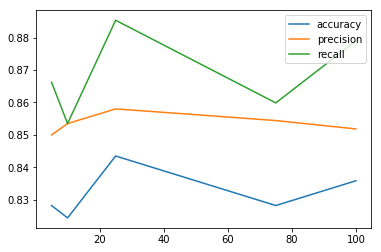

In [24]:
import matplotlib.pyplot as plt
x=rest[0]
y=rest[1]
plt.plot(rest[0],rest[1])
plt.plot(rest[0],rest[2])
plt.plot(rest[0],rest[3])
plt.legend(['accuracy','precision','recall'], loc='upper right')

plt.show()

I couldn't run B=200(ran overnight-still not completed), or 300. We see that accuracy is around 83% to 84%. B >10 is helpful, but atleast for this dataset, don't believe that we need B greater than 75

In [37]:
#Random Forest code

from numpy import random

x1=['pclass', 'male', 'age', 'sibsp', 'parch', 'fare',  'embarked_c','embarked_q','dest_NY','survived']
X1=titanic_df[x1]
X1['age'].fillna(np.mean(X1['age']), inplace=True)
X1['fare'].fillna(np.mean(X1['fare']), inplace=True)
train, test = train_test_split(X1, test_size=0.2, random_state=26)
result=pd.DataFrame()

def percen(z):
    x=pd.DataFrame(z.groupby(['survived'])['survived'].count().reset_index(name="count"))
    if(len(x)<=1):
        H=-(1*log(1,2))
        return(H)
    if(len(x)>1):        
        y1=(x.iloc[0,1]/(x.iloc[1,1]+x.iloc[0,1]))
        y2=(x.iloc[1,1]/(x.iloc[1,1]+x.iloc[0,1]))
    x['percent']=[y1,y2]
    H=-(y1*log(y1,2))-(y2*log(y2,2))
    return(H)

def entropy1(var,dat1):
    g=dat1[var].unique()
    g.sort()
    i=0
    fh1=pd.DataFrame()
    h1_l=0
    h1_g=0
    for i in range(0,len(g)):
        n1_g= dat1[dat1[var] >= g[i]]
        n1_l= dat1[dat1[var] < g[i]]
        if(len(n1_g)>0):
            h1_g=percen(n1_g)
        if(len(n1_l)>0):
            h1_l=percen(n1_l)
        fh1.at[i,0]=var
        fh1.at[i,1]=g[i]
        fh1.at[i,2]=(len(n1_g)/(len(n1_g)+len(n1_l)))*h1_g+(len(n1_l)/(len(n1_g)+len(n1_l)))*h1_l
    return fh1


#Paste the code

def ranForest(dat,xcol1):
    rest=list()
    sur_cnt=len(dat[dat['survived']==1])
    if(len(dat)>50 and len(xcol1)>0 and sur_cnt>0 and sur_cnt<len(dat)):
        fh1=pd.DataFrame()
        xcol=xcol1.copy()
        fh_final=pd.DataFrame()
        fh1=entropy1(xcol[0],dat)
        fh_final= fh1.copy()
        i=1
        j=len(xcol)
        for i in range(1,j):
            fh1=pd.DataFrame()
            v=xcol[i]
            fh1=entropy1(v,dat)
            fh_final=fh_final.append(fh1,ignore_index=True)
        fh_final.columns=['Column',"Column Threshold",'Entropy']
        y=fh_final.loc[fh_final['Entropy'].idxmin()]
        n1=y[0]
        n1_t=y[1]*1    
        n1_y=dat[dat[n1]>=n1_t]
        n1_n=dat[dat[n1]<n1_t]
        xcol.remove(n1)

        n1_y_res=ranForest(n1_y,xcol)        
        n1_n_res=ranForest(n1_n,xcol)    

        #rest=list()
        rest.append(n1)
        rest.append(n1_t)
        rest.append(n1_y_res)
        rest.append(n1_n_res)
        #rest.append(rest1)
        return(rest)
    else:
        return(rest)

def scoring(dat,mod,fin):
    if len(dat)==0:
        return
    if len(mod) == 0:
        fin1=pd.DataFrame()
        cnt=len(dat)
        sur_cnt=len(dat[dat['survived']==1])
        rat=sur_cnt/cnt
        fin1['actual']=dat['survived']
        if(rat> 0.5):
            fin1['predicted']=1
        else:
            fin1['predicted']=0
        #print(cnt,sur_cnt)
        #print(fin1)
        fin[0]=fin[0].append(fin1)
        return 
    p=mod[0]
    c=mod[1]
    
    n2_y=dat[dat[p]>=c]
    n2_n=dat[dat[p]<c]
    scoring(n2_y,mod[2],fin)
    scoring(n2_n,mod[3],fin)
    
def result_complete(dat,res):
    fin=[pd.DataFrame(columns=['actual','predicted'])]
    scoring(dat,res,fin)
    fin1=fin[0]
    return fin1


a=[5,10,25,50,75]
o=0
rest=pd.DataFrame()

for o in range(0,len(a)):
    final_test=pd.DataFrame()
    final_test=test['survived']
    for i in range(0,a[o]):
        train_boot=train.sample(len(train), replace=True)
        
        x1_col=['pclass', 'male', 'age', 'sibsp', 'parch', 'fare']
        x2_col=list(random.choice(x1_col,5))
        #x2_col = getRandom(x1_col,4)
        res= list()
        res=ranForest(train_boot,x2_col)
        fin1=result_complete(test,res)
        final_test = pd.concat([final_test, fin1['predicted']], axis=1)

    r=a[o]+1
    final_test.columns = np.arange(0,r)
    final_test['sum']=final_test.sum(axis=1)
    u=math.floor(a[o]/2)
    final_test['pred_vote']=((final_test['sum']-final_test[0])>u)*1
    temp1 = pd.DataFrame(pd.crosstab(final_test[0],final_test['pred_vote']))
    accuracy = (temp1.iloc[0].iloc[0]+temp1.iloc[1].iloc[1])/len(fin1)
    precision = temp1.iloc[0].iloc[0]/(temp1.iloc[0].iloc[0]+temp1.iloc[1].iloc[0])
    recall = temp1.iloc[0].iloc[0]/(temp1.iloc[0].iloc[0]+temp1.iloc[0].iloc[1])
    rest.at[o,0]=a[o]
    rest.at[o,1]=accuracy
    rest.at[o,2]=precision
    rest.at[o,3]=recall
    print(rest)
    
print(rest)


C:\Users\Sakura\Anaconda3\lib\site-packages\pandas\core\generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


     0         1         2         3
0  5.0  0.763359  0.748691  0.910828
      0         1         2         3
0   5.0  0.763359  0.748691  0.910828
1  10.0  0.835878  0.856250  0.872611
      0         1         2         3
0   5.0  0.763359  0.748691  0.910828
1  10.0  0.835878  0.856250  0.872611
2  25.0  0.847328  0.872611  0.872611
      0         1         2         3
0   5.0  0.763359  0.748691  0.910828
1  10.0  0.835878  0.856250  0.872611
2  25.0  0.847328  0.872611  0.872611
3  50.0  0.828244  0.854430  0.859873
      0         1         2         3
0   5.0  0.763359  0.748691  0.910828
1  10.0  0.835878  0.856250  0.872611
2  25.0  0.847328  0.872611  0.872611
3  50.0  0.828244  0.854430  0.859873
4  75.0  0.847328  0.867925  0.878981
      0         1         2         3
0   5.0  0.763359  0.748691  0.910828
1  10.0  0.835878  0.856250  0.872611
2  25.0  0.847328  0.872611  0.872611
3  50.0  0.828244  0.854430  0.859873
4  75.0  0.847328  0.867925  0.878981


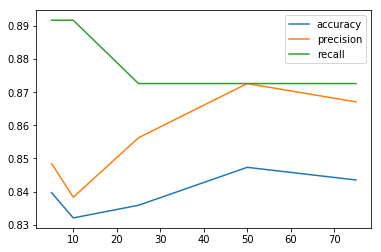

In [33]:
#Randomforest result
import matplotlib.pyplot as plt
x=rest[0]
y=rest[1]
plt.plot(rest[0],rest[1])
plt.plot(rest[0],rest[2])
plt.plot(rest[0],rest[3])
plt.legend(['accuracy','precision','recall'], loc='upper right')

plt.show()

Accuracy & Precision peaks at 50, but as I am not able to run RF on more than 75B, I cannot conclude that 50 is the best. Performance might improve as the size increases. For the available speed, 50 seems the best

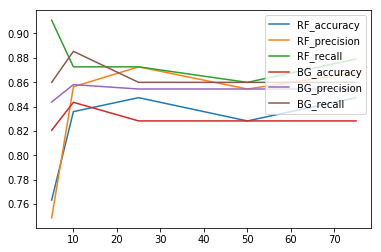

In [38]:
x=rest[0]
y=rest[1]
plt.plot(rest[0],rest[1])
plt.plot(rest[0],rest[2])
plt.plot(rest[0],rest[3])
plt.plot(rest[0],rest1s[1])
plt.plot(rest[0],rest1s[2])
plt.plot(rest[0],rest1s[3])
plt.legend(['RF_accuracy','RF_precision','RF_recall','BG_accuracy','BG_precision','BG_recall'], loc='upper right')

plt.show()

Random forest has improved accuracy, but not much greater than bagging at least for this dataset. Would be nice to try RF on different datasets